# Darcy Equation

## Preliminary steps

Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from matplotlib.colors import Normalize
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train-test split

In [2]:
def get_data(filename, ndata, r):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29 - basically r selects the course-grainedness, r=1 means no course-graining
    r = r
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = scipy.io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float32) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float32) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x[0], y, grid

r = 15
s = int(((421 - 1) / r) + 1)

x_train, y_train, train_grid = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth1.mat", 1000, r)
x_test, y_test, test_grid = get_data("../darcy_flow_data/rect_cont_PWC/piececonst_r421_N1024_smooth2.mat", 1000, r)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1000, 841) (1000, 841)
(1000, 841) (1000, 841)


visualise input/output data

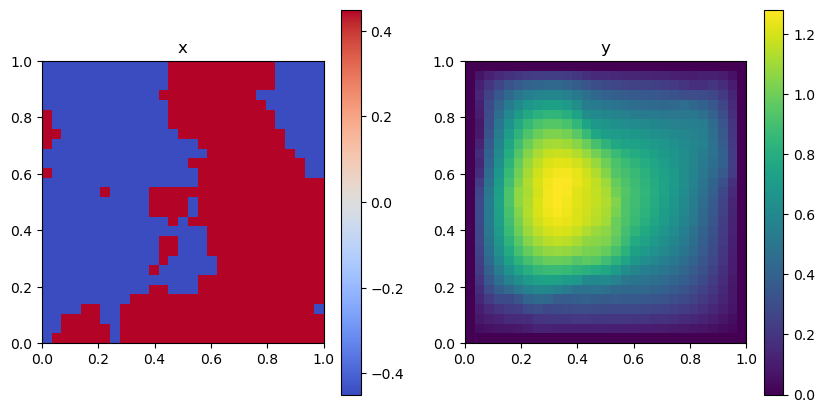

In [3]:
index_to_plot = 12

# print(len(x_train), x_train.shape, x_train[1].shape, y_train.shape)
# print(len(x_test), x_test.shape, x_test[1].shape, y_test.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[1].set_title("y")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
plt.show()

## Model definition

In [4]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise):
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = np.ones(self.n)
        else:
            ls = 1.0

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        self.x_pca = PCA(n_components = self.n)
        self.y_pca = PCA(n_components = self.m)
        self.x_train_pca = self.x_pca.fit_transform(self.x_train)
        self.y_train_pca = self.y_pca.fit_transform(self.y_train)

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))
            train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)

        if n_samples is not None:
            for i in range(n_samples):
                train_samples_pca_i = train_samples_pca[:, :, i]
                train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
                train_samples[:, :, i] = train_samples_i
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
            test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca.append(local_gp.predict(self.x_test_pca))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            y_pred_pca = np.stack(y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(y_pred_pca)

        if n_samples is not None:
            for i in range(n_samples):
                test_samples_pca_i = test_samples_pca[:, :, i]
                test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
                test_samples[:, :, i] = test_samples_i
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

## determine `n` and `m`

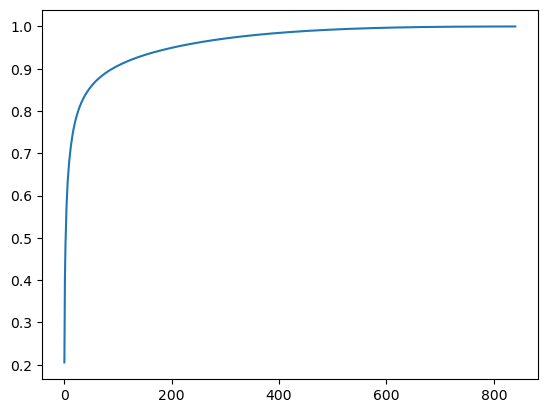

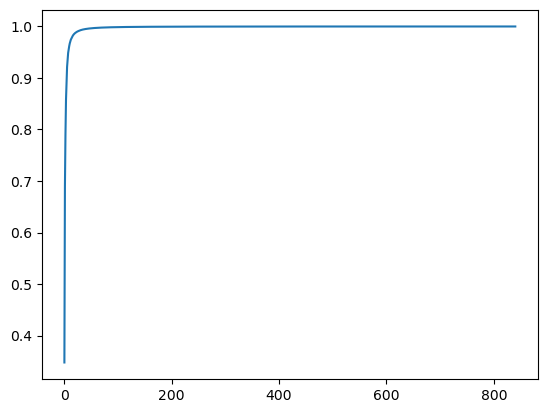

202 24


In [5]:
# determine n
x_pca = PCA(n_components=x_train.shape[-1])
x_train_pca = x_pca.fit_transform(x_train)

plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.show()

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > 0.95)[0][0]

# determine m
y_pca = PCA(n_components=y_train.shape[-1])
y_train_pca = y_pca.fit_transform(y_train)

plt.plot(np.cumsum(y_pca.explained_variance_ratio_))
plt.show()

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > 0.99)[0][0]

print(n, m)

## Train

In [6]:
n_samples = 6

model = full_model(n = n, m = m, ARD = False, multiinput = True, standardise = False)
train_samples = model.fit(x_train, y_train, n_samples = None)

  0%|          | 0/24 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  likelihood = like

         Current function value: 2474.810791
         Iterations: 4
         Function evaluations: 76
         Gradient evaluations: 64
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0124369, dtype=float32), variance=Array(0.30994254, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(2.8246148, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
  8%|▊         | 2/24 [01:26<16:56, 46.19s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: 1237.356445
         Iterations: 7
         Function evaluations: 148
         Gradient evaluations: 136
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(4.8052306, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.49878797, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 12%|█▎        | 3/24 [01:56<13:32, 38.68s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: 1853.916260
         Iterations: 1
         Function evaluations: 55
         Gradient evaluations: 43
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0000162, dtype=float32), variance=Array(1.0727345, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(1.1466238, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 17%|█▋        | 4/24 [02:28<12:01, 36.07s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: 941.975281
         Iterations: 5
         Function evaluations: 77
         Gradient evaluations: 65
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(9.996446, dtype=float32), variance=Array(1.8692346, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.5717977, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 21%|██        | 5/24 [03:05<11:29, 36.27s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: 978.712952
         Iterations: 7
         Function evaluations: 87
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(9.120518, dtype=float32), variance=Array(0.19525072, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.8587916, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 25%|██▌       | 6/24 [03:50<11:48, 39.37s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: 1232.698730
         Iterations: 5
         Function evaluations: 87
         Gradient evaluations: 75
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0021887, dtype=float32), variance=Array(0.01047502, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.823742, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 29%|██▉       | 7/24 [05:10<14:53, 52.56s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: -485.126190
         Iterations: 30
         Function evaluations: 117
         Gradient evaluations: 105
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.07415134, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000034, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 33%|███▎      | 8/24 [06:30<16:22, 61.41s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: -497.785492
         Iterations: 28
         Function evaluations: 125
         Gradient evaluations: 113
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.07230262, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000322, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 38%|███▊      | 9/24 [07:19<14:21, 57.42s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested i

         Current function value: 505.832550
         Iterations: 5
         Function evaluations: 88
         Gradient evaluations: 77
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.005353, dtype=float32), variance=Array(0.12733968, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.18353772, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 42%|████▏     | 10/24 [08:04<12:30, 53.58s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: 478.483948
         Iterations: 6
         Function evaluations: 85
         Gradient evaluations: 74
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0071516, dtype=float32), variance=Array(0.12159929, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.17564692, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 46%|████▌     | 11/24 [09:23<13:20, 61.55s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -737.064514
         Iterations: 28
         Function evaluations: 115
         Gradient evaluations: 103
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.04470292, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000111, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 50%|█████     | 12/24 [10:44<13:28, 67.37s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -792.454712
         Iterations: 30
         Function evaluations: 112
         Gradient evaluations: 100
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.0399863, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000018, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 54%|█████▍    | 13/24 [12:16<13:43, 74.87s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -772.727905
         Iterations: 29
         Function evaluations: 189
         Gradient evaluations: 176
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.04161154, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000156, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 58%|█████▊    | 14/24 [13:01<10:59, 65.93s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -41.112267
         Iterations: 4
         Function evaluations: 86
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0028849, dtype=float32), variance=Array(0.05031746, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.06008578, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 62%|██████▎   | 15/24 [14:09<09:58, 66.47s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -901.511536
         Iterations: 23
         Function evaluations: 111
         Gradient evaluations: 99
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.03210478, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000142, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 67%|██████▋   | 16/24 [15:28<09:22, 70.29s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -931.070374
         Iterations: 26
         Function evaluations: 128
         Gradient evaluations: 117
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.03024208, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.0100005, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 71%|███████   | 17/24 [17:10<09:18, 79.78s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -940.883850
         Iterations: 23
         Function evaluations: 185
         Gradient evaluations: 162
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.02964688, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000117, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 75%|███████▌  | 18/24 [18:02<07:09, 71.50s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -302.218445
         Iterations: 5
         Function evaluations: 91
         Gradient evaluations: 81
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0105276, dtype=float32), variance=Array(0.03032136, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.04086323, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 79%|███████▉  | 19/24 [19:12<05:54, 70.93s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -1049.399658
         Iterations: 25
         Function evaluations: 105
         Gradient evaluations: 93
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.02381477, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000047, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 83%|████████▎ | 20/24 [20:07<04:24, 66.24s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -1040.541870
         Iterations: 8
         Function evaluations: 99
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(9.975633, dtype=float32), variance=Array(0.02692741, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.0363865, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 88%|████████▊ | 21/24 [21:15<03:19, 66.53s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -1107.894043
         Iterations: 7
         Function evaluations: 111
         Gradient evaluations: 99
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(9.996079, dtype=float32), variance=Array(0.02159877, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.03190988, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 92%|█████████▏| 22/24 [21:49<01:54, 57.04s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -562.941162
         Iterations: 7
         Function evaluations: 87
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0065203, dtype=float32), variance=Array(0.01815931, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.02880528, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
 96%|█████████▌| 23/24 [24:27<01:27, 87.13s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested 

         Current function value: -1162.930542
         Iterations: 30
         Function evaluations: 203
         Gradient evaluations: 191
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(10., dtype=float32), variance=Array(0.01890041, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000062, dtype=float32))


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
100%|██████████| 24/24 [24:55<00:00, 62.31s/it]

         Current function value: -639.558350
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 61
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.0128899, dtype=float32), variance=Array(0.01561206, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.02608019, dtype=float32))


## Assess performance on training data

In [7]:
n_samples = 6

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

print(train_samples.shape)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

  4%|▍         | 1/24 [00:06<02:20,  6.09s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 24/24 [01:29<00:00,  3.71s/it]


(1000, 841, 6)
median relative L2 (train data): 0.13772723078727722
mean relative L2 (train data): 0.14520049095153809


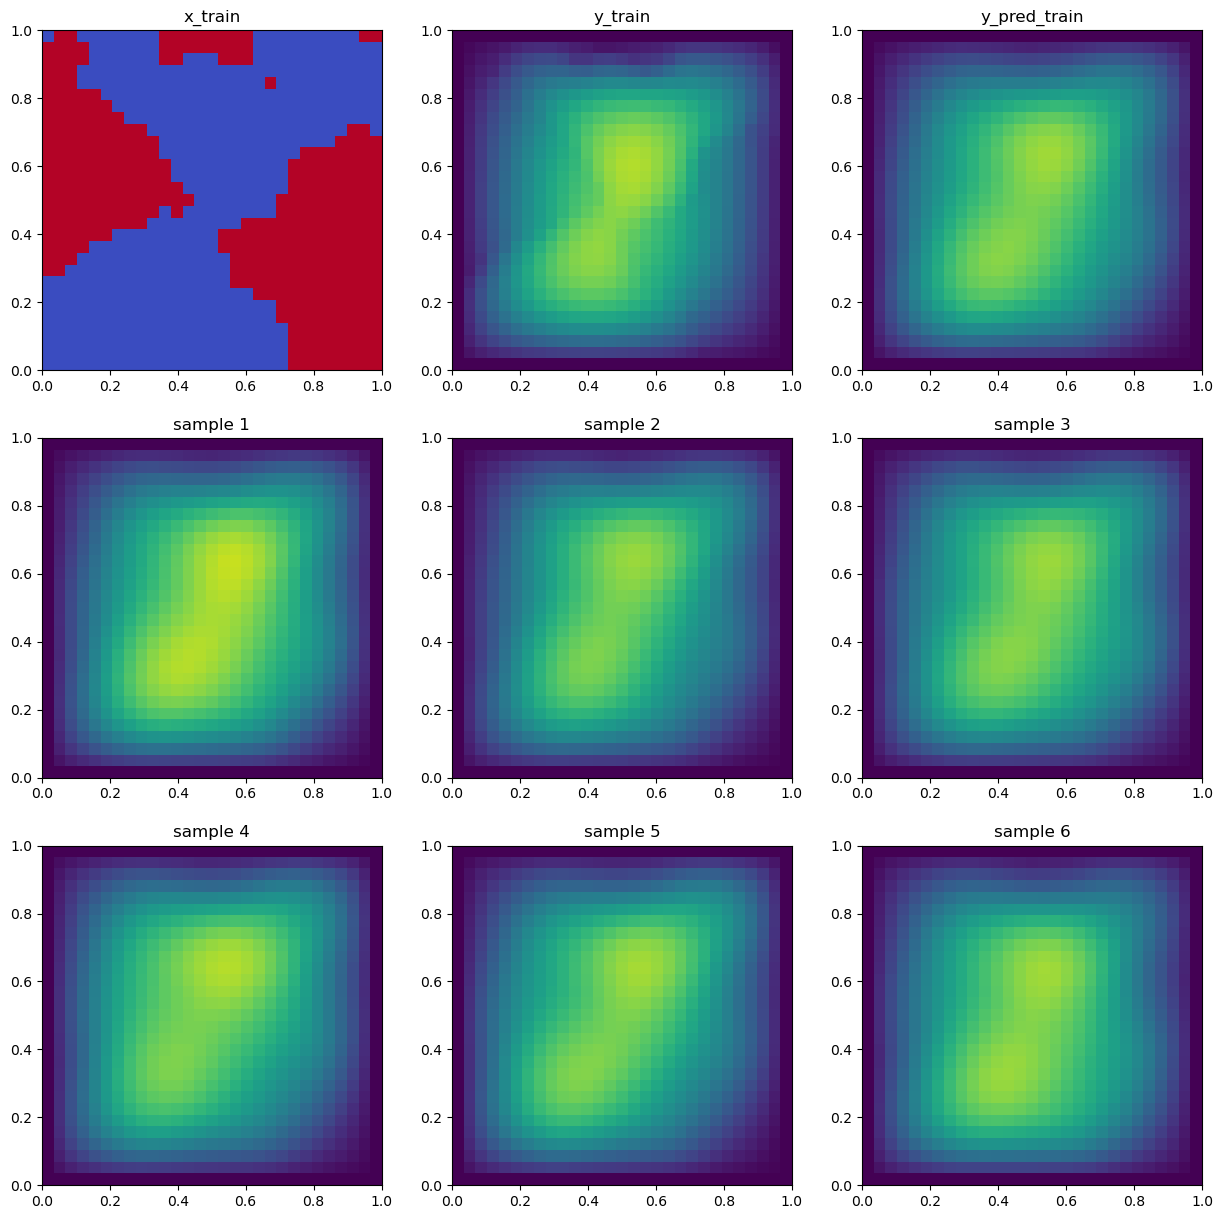

In [14]:
index_to_plot = 127

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_train[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_train[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x_train")
im1 = ax[1].imshow(y_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_train")
im2 = ax[2].imshow(y_pred_train[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_train")
for i in range(6):
    imi = ax[i+3].imshow(train_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## Test

In [9]:
n_samples = 100

y_pred_test, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_test - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:03<01:17,  3.39s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 24/24 [01:24<00:00,  3.51s/it]


median relative L2: 0.1682494580745697
mean relative L2: 0.1709112524986267


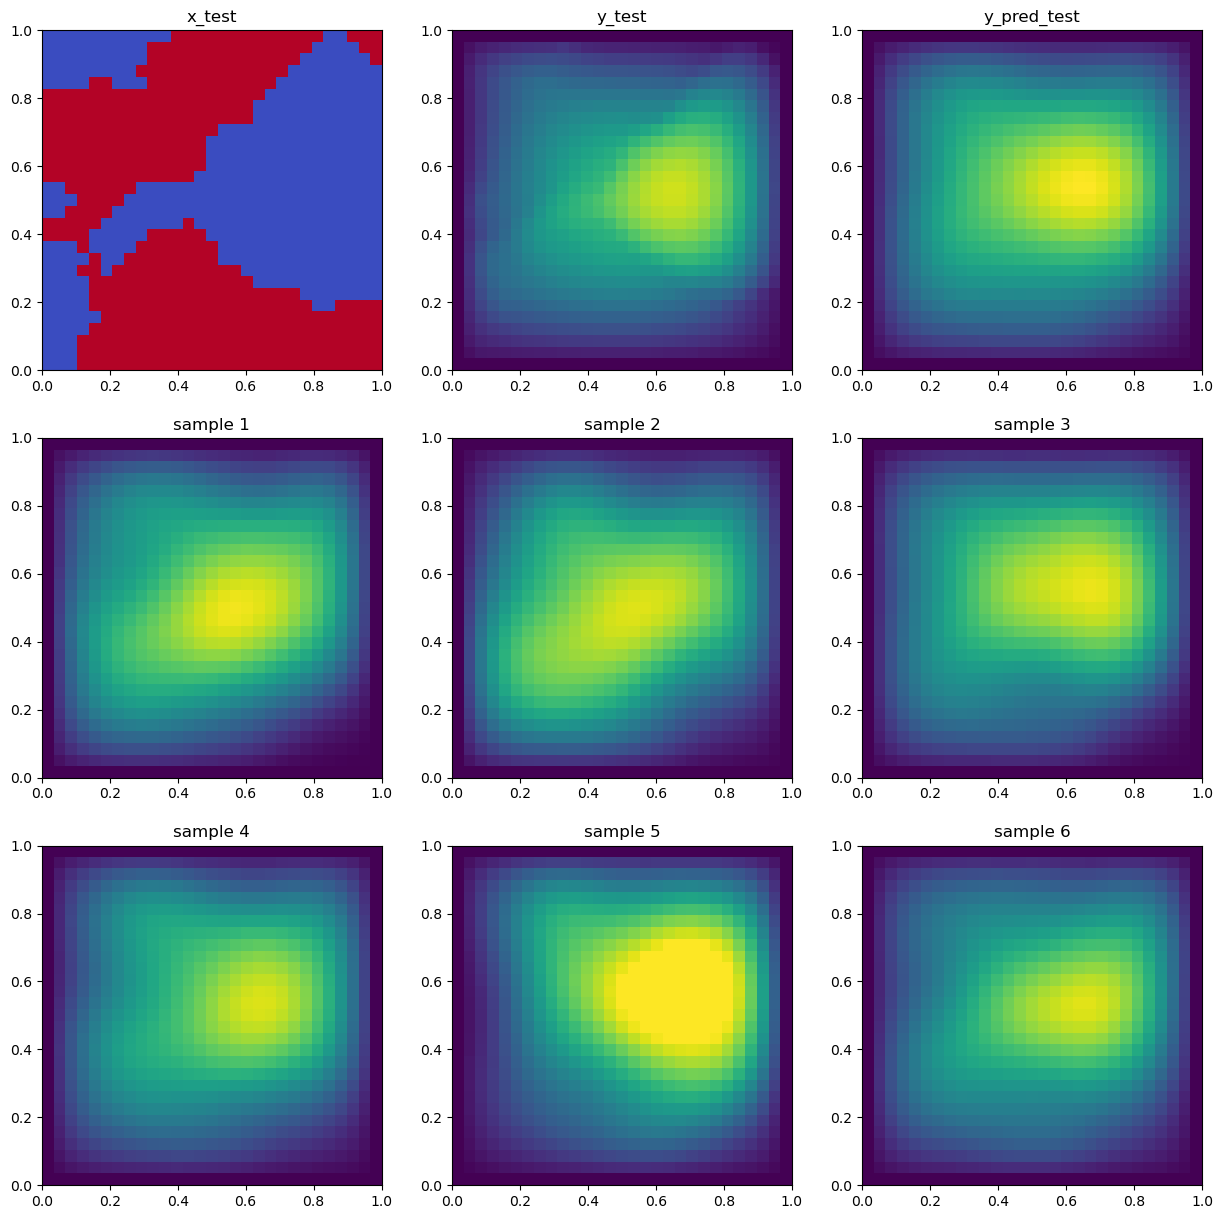

In [10]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), y_pred_test[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), y_pred_test[index_to_plot, :].max())])

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(y_pred_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title("y_pred_test")
for i in range(6):
    imi = ax[i+3].imshow(test_samples[index_to_plot, :, i].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
    ax[i+3].set_title(f"sample {i+1}")
    
            # ax[i].legend()
plt.show()

## analyse uncertainty

In [11]:
print(test_samples.shape)

test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

(1000, 841, 100)


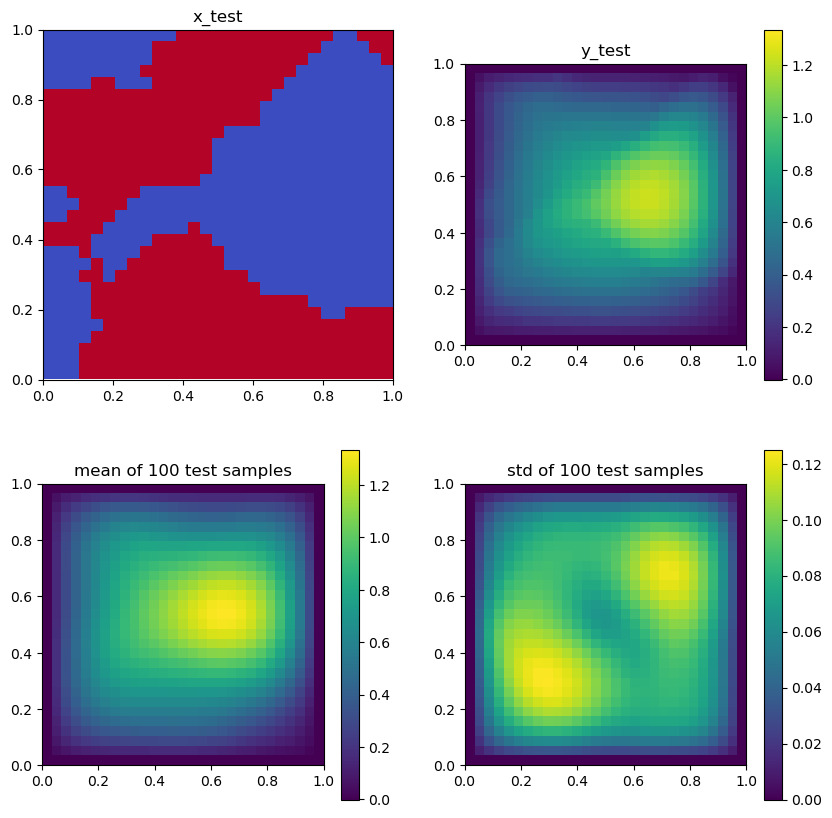

In [12]:
index_to_plot = 125

y_lims = np.array([min(y_test[index_to_plot, :].min(), test_samples_mean[index_to_plot, :].min()), max(y_test[index_to_plot, :].max(), test_samples_mean[index_to_plot, :].max())])

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.flatten()

im0 = ax[0].imshow(x_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], cmap='coolwarm')
ax[0].set_title("x_test")
im1 = ax[1].imshow(y_test[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[1].set_title("y_test")
im2 = ax[2].imshow(test_samples_mean[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1], norm=Normalize(vmin=y_lims[0], vmax=y_lims[1]))
ax[2].set_title(f"mean of {n_samples} test samples")
im3 = ax[3].imshow(test_samples_std[index_to_plot, :].reshape(s, s), origin='lower', extent=[0, 1, 0, 1])
ax[3].set_title(f"std of {n_samples} test samples")
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])
